In [6]:
import pylsl
import time
from random import random as rand
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

In [2]:
def discrete_sine(t: np.array, f: float, delay: float = 0.0, fs: float = 250.0) -> np.array:
    ''' Generate a sine wave

    Args:
        `t` (`np.array`): Discrete time (n) array

        `f` (`float`): Frequency in Hz

        `delay` (`float`): Delay in discrete time. Default: 0.0

        `fs` (`float`): Sampling rate in Hz. Default: 250.0

    Returns:
        `float`: Sine wave array in discrete time (n)
    '''
    F = f/fs
    return np.sin(2*np.pi*F*(t+delay))

def sum_sines(t: np.array, f_list: list[float], scaling: list[float], delay: float = 0.0, fs: float = 250.0) -> np.array:
    ''' Generate a sine wave

    Args:
        `t` (`np.array`): Discrete time (n) array

        `f_list` (`list[float]`): List of frequencies in Hz

        `scaling` (`list[float]`): List of coefficients to scale each sinusoid

        `delay` (`float`): Delay in discrete time. Default: 0.0

        `fs` (`float`): Sampling rate in Hz. Default: 250.0

    Returns:
        `float`: Sine wave array in discrete time (n)
    '''
    return np.sum([s*discrete_sine(t, f, delay=delay, fs=fs) for f, s in list(zip(f_list, scaling))], axis=0)

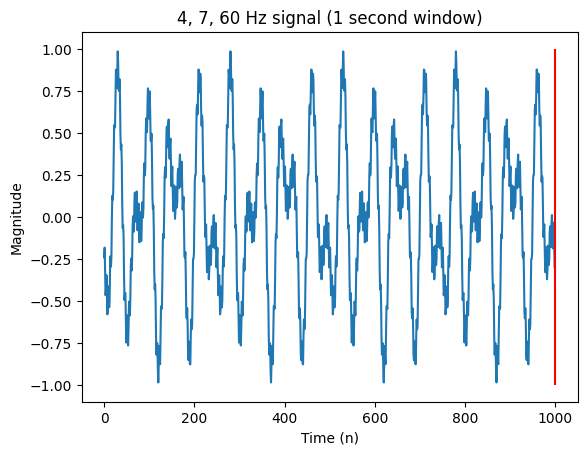

In [15]:
# Sampling rate Hz (Cyton board)
fs = 250

seconds = 4
num_samples = fs*seconds
frequencies = [4, 7, 60]
scaling = [0.5, 0.4, 0.1]

t = np.array([*range(num_samples)])
ch1 = sum_sines(t, frequencies, fs=fs, scaling=scaling, delay=50)

plt.plot(t, ch1)
plt.title('4, 7, 60 Hz signal (1 second window)')
plt.xlabel('Time (n)')
plt.ylabel('Magnitude')
plt.vlines(1000, -1, 1, color='red')

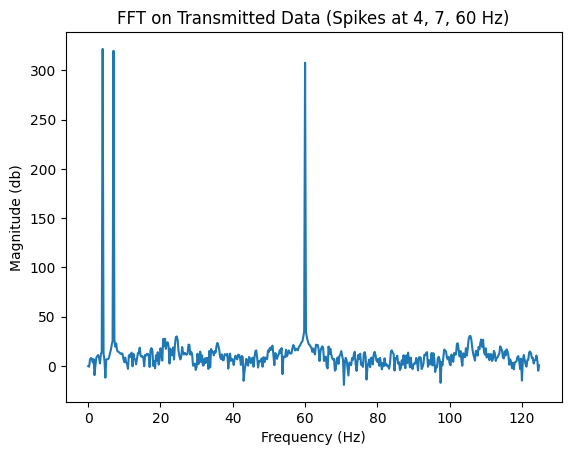

In [14]:
# Sample count
N = len(ch1)
# Sampling rate
fs = 250

# Sample spacing (inverse of sampling rate)
df = 1/fs

'''
FFT and frequency time scale
Halve the frequency domain due to real-time signal conjugate symmetry
'''
yf = fft(ch1)[:N//2]
xf = fftfreq(N, df)[:N//2]

'''
Convert power signal to normalized decibel
'''
yf_plot = 20*np.log10(np.abs(yf)/np.max(yf))
yf_plot -= yf_plot[0]

plt.title('FFT on Transmitted Data (Spikes at 4, 7, 60 Hz)')
plt.ylabel('Magnitude (db)')
plt.xlabel('Frequency (Hz)')
plt.plot(xf, yf_plot)

In [4]:
name = 'LSLExample'
stream_type = 'EEG'
channel_names = ["Fp1", "Fp2"]
n_channels = 1#len(channel_names)

info = pylsl.StreamInfo(name, stream_type, n_channels, fs, 'float32', 'myuid2424')

# info.desc().append_child_value("manufacturer", "LSLExampleAmp")
# chns = info.desc().append_child("channels")
# for chan_ix, label in enumerate(channel_names):
#     ch = chns.append_child("channel")
#     ch.append_child_value("label", label)
#     ch.append_child_value("unit", "microvolts")
#     ch.append_child_value("type", "EEG")
#     ch.append_child_value("scaling_factor", "1")
#     loc = ch.append_child("location")

outlet = pylsl.StreamOutlet(info, 32, 320)
print("now sending data...")
start_time = pylsl.local_clock()
sent_samples = 0
while True:
    elapsed_time = pylsl.local_clock() - start_time
    required_samples = int(fs * elapsed_time) - sent_samples
    if required_samples > 0:
        mychunk = [
            list(sum_sines(t, frequencies, fs=fs, scaling=scaling, delay=fs*elapsed_time))
            for _ in range(required_samples)
        ]
        # print(len(mychunk))
        # Get a time stamp in seconds. We pretend that our samples are actually
        # 125ms old, e.g., as if coming from some external hardware with known latency.
        stamp = pylsl.local_clock() - 0.125
        # now send it and wait for a bit

        # the `push_chunk` method will convert it to c_float before passing the data to liblsl.
        outlet.push_chunk(mychunk, stamp)
        sent_samples += required_samples
    time.sleep(0.02)

now sending data...


KeyboardInterrupt: 